<a href="https://colab.research.google.com/github/madjouradem/tomato-diseases-detection-model-using-CNN/blob/master/tomato_diseases_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#d


# Import necessary libraries

In [ ]:

# # Plant Disease Classification using CNN

# This notebook demonstrates how to classify plant diseases using a Convolutional Neural Network (CNN)

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import shutil
import math




#get the dataset

In [ ]:


# download the dataset from kaggle {https://www.kaggle.com/datasets/arjuntejaswi/plant-village}
!kaggle datasets download  'arjuntejaswi/plant-village'
!unzip plant-village.zip

# remove the folders that are not needed
shutil.rmtree('PlantVillage/Pepper__bell___Bacterial_spot')
shutil.rmtree('PlantVillage/Pepper__bell___healthy')
shutil.rmtree('PlantVillage/Potato___Early_blight')
shutil.rmtree('PlantVillage/Potato___healthy')
shutil.rmtree('PlantVillage/Potato___Late_blight')




In [ ]:
# Load the dataset using image_dataset_from_directory
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
    )

Found 16011 files belonging to 10 classes.


In [ ]:
#  Get class names
classes_names = ds.class_names
classes_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

Tomato_Spider_mites_Two_spotted_spider_mite
Tomato__Target_Spot
Tomato_Bacterial_spot
Tomato_Early_blight
Tomato_healthy
Tomato_Septoria_leaf_spot
Tomato_Septoria_leaf_spot
Tomato_Septoria_leaf_spot
Tomato_Bacterial_spot
Tomato_Bacterial_spot
Tomato_healthy
Tomato_Early_blight


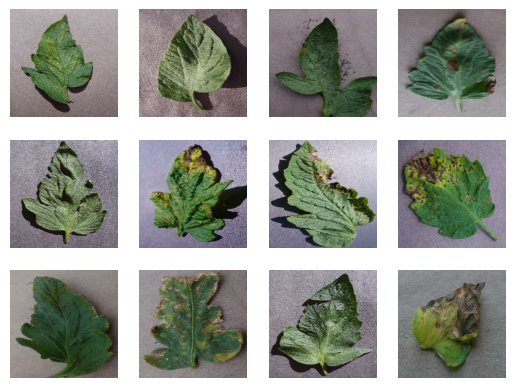

In [ ]:
# Display some images from the dataset

for image_batch , labels_batch in ds.take(1):

  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')
    print(classes_names[labels_batch[i].numpy()])


# Data Splitting

In [ ]:

# # Data Splitting
def split_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  if shuffle:
    ds.shuffle(shuffle_size,seed=12)

  ds_size = len(ds)
  train_size = round(ds_size*train_split)
  val_size = round(ds_size*val_split)
  test_size = round(ds_size*test_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(val_size+train_size).take(test_size)
  return train_ds,val_ds,test_ds

train_ds,val_ds,test_ds= split_dataset(ds)
print(len(train_ds),len(val_ds),len(test_ds))



401 50 50


In [ ]:
# Cache, shuffle, and prefetch the datasets for performance
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Define input shape and preprocessing layers
input_shape = (32,256,256,3)
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(256, 256,input_shape=input_shape[1:]),
  layers.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Define the CNN model using the Sequential API
model = models.Sequential([
 # Resize and rescale the input images using the resize_and_rescale preprocessing layer
  resize_and_rescale,
  # Apply data augmentation to the images using the data_augmentation preprocessing layer
  data_augmentation,
  # First convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and specified input shape
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
 # First max pooling layer with a 2x2 pool size
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),

#  Flatten the output from the convolutional layers into a 1D vector
  tf.keras.layers.Flatten(),
 # First fully connected (dense) layer with 64 units and ReLU activation
  tf.keras.layers.Dense(64, activation='relu'),

# Output layer
  tf.keras.layers.Dense(len(classes_names),activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,794 (182.79 KB)

 Trainable params: 46,794 (182.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
# This step configures the model for training by specifying:
# - Loss function: SparseCategoricalCrossentropy (used for multi-class classification with integer labels)
# - Optimizer: Adam (a popular optimization algorithm)
# - Metrics: Accuracy (to evaluate the model's performance)
# from_logits=False indicates that the output layer uses a softmax activation function
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy','recall', 'precision', 'f1_score']) # Added loss, optimizer, and met


# Train the model
# This step initiates the training process using the following parameters:
# - train_ds: The training dataset
# - epochs: The number of times the model will iterate over the entire training dataset (50 in this case)
# - batch_size: The number of samples processed before updating the model's weights (32 in this case)
# - validation_data: The validation dataset used to monitor performance and prevent overfitting
# - verbose: Controls the amount of output displayed during training (1 for progress updates per epoch)
model.fit(train_ds,epochs=50, batch_size=32, validation_data=val_ds,verbose=1)

Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.3015 - loss: 1.9256 - val_accuracy: 0.5619 - val_loss: 1.3039
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.6170 - loss: 1.1156 - val_accuracy: 0.6313 - val_loss: 1.0776
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - accuracy: 0.7088 - loss: 0.8447 - val_accuracy: 0.6944 - val_loss: 0.9150
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.7814 - loss: 0.6204 - val_accuracy: 0.7569 - val_loss: 0.6707
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.8060 - loss: 0.5528 - val_accuracy: 0.8025 - val_loss: 0.5536
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.8300 - loss: 0.4886 - val_accuracy: 0.8363 - val_loss: 0.4555
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8496 - loss: 0.4201 - val_accuracy: 0.7300 - val_loss: 0.8337
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.8587 - loss: 0.4079 - 

In [ ]:
accuracy, recall, precision, f1_score = model.evaluate(test_ds)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1 Score: ", f1_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


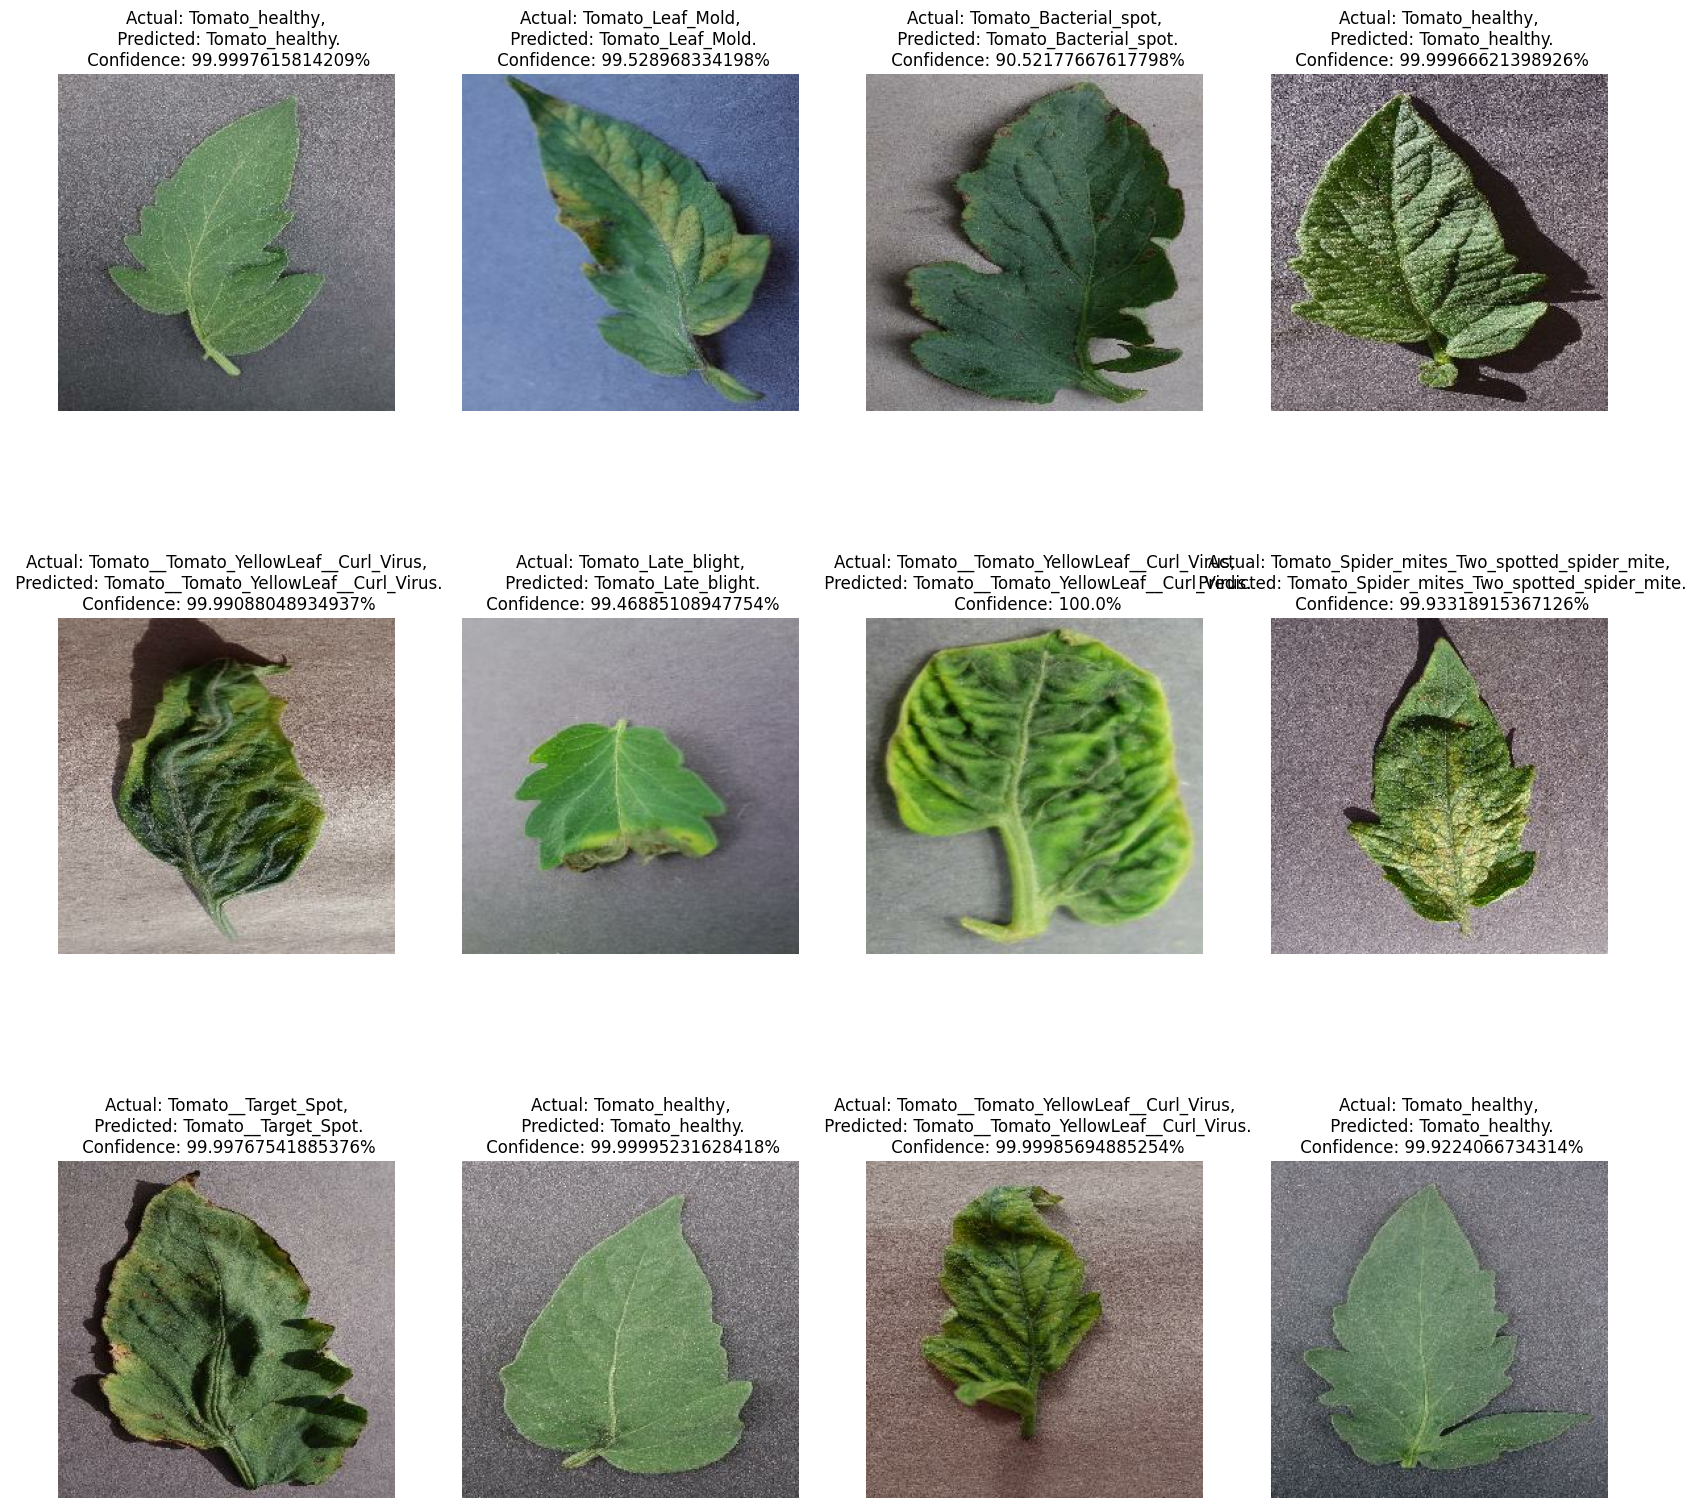

In [ ]:

plt.figure(figsize=(20, 20))

# Iterate through the first batch of images and labels from the test dataset
for image_batch , labels_batch in test_ds.take(1) :
  for i in range(12):
    # Make predictions on a single image using the trained model
    predictions = model.predict(tf.expand_dims(image_batch[i], axis=0))
    # Get the actual class name
    pred_image_class = classes_names[np.argmax(predictions)]
    confidence = round(np.max(predictions) * 100)

    # Get the actual class name from the labels batch
    actual_class_name = classes_names[labels_batch[i]]

    ax = plt.subplot(3, 4, i + 1)
    plt.title(f"Actual: {actual_class_name},\n Predicted: {pred_image_class}.\n Confidence: {confidence}%")
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')

accuracy = np.array(model.predict(test_ds.take(1)))
print(accuracy[0])


In [ ]:
# export model from colab
from google.colab import files

model_save_path = '/content'
model.export(model_save_path)
files.download('./saved_model.pb')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved artifact at '/content'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135719765721328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719765722736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719765885696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719763922784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719763929120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719763923488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719763930880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719763928240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135719763932640: TensorSpec(sh